# 1. Importação das bibliotecas, definição dos métodos e tratamento inicial




In [1]:
%%capture
!pip install ray
!pip install unicode
!pip install unidecode
!pip install boruta
!pip install catboost
!pip install openpyxl

In [2]:
import pandas as pd
import ray
import plotly.express as px
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import numpy as np
import unidecode
from scipy import stats
from google.colab import drive
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def find_best_lambda(data, lambda_range):
    best_lambda = None
    best_llf = -np.inf  # initialize with negative infinity

    for lmbda in lambda_range:
        llf = stats.yeojohnson_llf(lmbda, data)
        if llf > best_llf:
            best_llf = llf
            best_lambda = lmbda

    return best_lambda

In [5]:
def remove_accents(a):
  a = a.encode('utf-8', errors='ignore')
  return unidecode.unidecode(a.decode('utf-8'))

In [6]:
cadunico = pd.read_csv("/content/drive/MyDrive/Hunger prediction/data/Brazil/cadunico_data_brazil.csv")
sisvan = pd.read_excel("/content/drive/MyDrive/Hunger prediction/data/Brazil/peso_altura.xlsx")

In [7]:
sisvan

,PESO X ALTURA,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17
0,Região,Código UF,UF,Código IBGE,Município,Magreza\nacentuada,NaN,Magreza,NaN,Peso Adequado\nou Eutrófico,NaN,Risco de sobrepeso,NaN,Sobrepeso,NaN,Obesidade,NaN,Total
1,NaN,NaN,NaN,NaN,NaN,Quantidade,%,Quantidade,%,Quantidade,%,Quantidade,%,Quantidade,%,Quantidade,%,NaN
2,CENTRO-OESTE,53,DF,530010,BRASILIA,862,1.13%,2575,3.37%,56677,74.2%,10833,14.18%,3400,4.45%,2037,2.67%,76384
3,TOTAL ESTADO DISTRITO FEDERAL,NaN,NaN,NaN,NaN,862,1.13%,2575,3.37%,56677,74.2%,10833,14.18%,3400,4.45%,2037,2.67%,76384
4,CENTRO-OESTE,52,GO,520005,ABADIA DE GOIAS,4,1.16%,8,2.33%,232,67.44%,68,19.77%,19,5.52%,13,3.78%,344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5604,TOTAL BRASIL,NaN,NaN,NaN,NaN,110553,1.69%,167854,2.56%,4286539,65.38%,1168677,17.82%,460889,7.03%,362327,5.53%,6556839
5605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5607,VersÃ£o 3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
sisvan[sisvan.columns[6]][0] = 'Magreza\nacentuada (%)'
sisvan[sisvan.columns[8]][0] = 'Magreza (%)'
sisvan[sisvan.columns[10]][0] = 'Peso Adequado\nou Eutrófico (%)'
sisvan[sisvan.columns[12]][0] = 'Risco de sobrepeso (%)'
sisvan[sisvan.columns[14]][0] = 'Sobrepeso (%)'
sisvan[sisvan.columns[16]][0] = 'Obesidade (%)'

sisvan.dropna(inplace=True)

sisvan.columns = sisvan.iloc[0]
sisvan = sisvan[1:]
sisvan.reset_index(drop=True, inplace=True)

for i, val in enumerate(sisvan['Município']):
  val += ' - '
  val += sisvan['UF'][i]
  sisvan['Município'][i] = val

sisvan = sisvan.iloc[:, [4, 6, 8]]

sisvan.replace(['%'], [''], regex=True, inplace=True)
sisvan['Município'] = sisvan['Município'].apply(remove_accents)

for col in sisvan.columns[1:]:
  sisvan[col].replace(['-'], [0], regex=True, inplace=True)
  sisvan[col] = sisvan[col].astype(float)

sisvan['Município'] = sisvan['Município'].str.lower()

sisvan['Peso/Altura < Escore-z -2 (%)'] = sisvan[sisvan.columns[1]] + sisvan[sisvan.columns[2]]
sisvan.drop(columns=sisvan.columns[1:3], inplace=True)

<ipython-input-8-6e0f373953c9>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sisvan['Município'][i] = val
<ipython-input-8-6e0f373953c9>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sisvan.replace(['%'], [''], regex=True, inplace=True)
<ipython-input-8-6e0f373953c9>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sisvan['Município'] = sisvan['Município'].apply(remove_a

In [9]:
cadunico['Município'] = cadunico['Município'].str.lower()
cadunico['Município'] = cadunico['Município'].apply(remove_accents)

In [10]:
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', None)
cadunico

,Município,Estado cadastral da família / Sem Registro Civil,Estado cadastral da família / Cadastrado,Faixa da renda total da família / Até 1 S.M.,Faixa da renda total da família / Entre 1 e 2 S.M.,Faixa da renda total da família / Entre 2 e 3 S.M.,Faixa da renda total da família / Acima de 3 S.M.,Faixa da renda familiar per capita / Pobreza 1 (até R$ 109),Faixa da renda familiar per capita / Pobreza 2 (de R$ 109 a R$ 218),Faixa da renda familiar per capita / Baixa Renda,Faixa da renda familiar per capita / Acima de 1/2 S.M.,Forma de coleta / Informação migrada como inexistente,Forma de coleta / Sem visita Domiciliar,Forma de coleta / Com visita domiciliar,Número de meses após a última atualização cadastral / até 12 Meses,Número de meses após a última atualização cadastral / 13 a 18 Meses,Número de meses após a última atualização cadastral / 19 a 24 Meses,Número de meses após a última atualização cadastral / 25 a 36 Meses,Número de meses após a última atualização cadastral / 37 a 48 Meses,Número de meses após a última atualização cadastral / acima de 48 Meses,Recebe PBF família / Não,Recebe PBF família / Sim,Calçamento em frente ao seu domicílio / Total,Calçamento em frente ao seu domicílio / Parcial,Calçamento em frente ao seu domicílio / Não existe,Situação do domicílio / Urbanas,Situação do domicílio / Rurais,Espécie do domicílio / Particular Permanente,Espécie do domicílio / Particular improvisado,Espécie do domicílio / Coletivo,Existência de banheiro / Sim,Existência de banheiro / Não,Forma de abastecimento de água / Rede geral de distribuição,Forma de abastecimento de água / Poço ou nascente,Forma de abastecimento de água / Cisterna,Forma de abastecimento de água / Outra forma,Forma de coleta do lixo / É coletado diretamente,Forma de coleta do lixo / É coletado indiretamente,Forma de coleta do lixo / É queimado ou enterrado na propriedade,"Forma de coleta do lixo / É jogado em terreno baldio ou logradouro (rua, avenida, etc.)",Forma de coleta do lixo / É jogado em rio ou mar,Forma de coleta do lixo / Tem outro destino,Forma de escoamento sanitário / Rede coletora de esgoto ou pluvial,Forma de escoamento sanitário / Fossa séptica,Forma de escoamento sanitário / Fossa rudimentar,Forma de escoamento sanitário / Vala a céu aberto,"Forma de escoamento sanitário / Direto para um rio, lago ou mar",Forma de escoamento sanitário / Outra forma,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo com revestimento,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo sem revestimento,Material predominante nas paredes externas do domicílio / Madeira aparelhada,Material predominante nas paredes externas do domicílio / Taipa revestida,Material predominante nas paredes externas do domicílio / Taipa não revestida,Material predominante nas paredes externas do domicílio / Madeira aproveitada,Material predominante nas paredes externas do domicílio / Palha,Material predominante nas paredes externas do domicílio / Outro Material,Material predominante no piso do domicílio / Terra,Material predominante no piso do domicílio / Cimento,Material predominante no piso do domicílio / Madeira aproveitada,Material predominante no piso do domicílio / Madeira aparelhada,"Material predominante no piso do domicílio / Cerâmica, lajota ou pedra",Material predominante no piso do domicílio / Carpete,Material predominante no piso do domicílio / Outro Material,Água canalizada no domicílio / Sim,Água canalizada no domicílio / Não,Tipo de iluminação / Elétrica com medidor próprio,Tipo de iluminação / Elétrica com medidor comunitário,Tipo de iluminação / Elétrica sem medidor,"Tipo de iluminação / Óleo, querosene ou gás",Tipo de iluminação / Vela,Tipo de iluminação / Outra forma,Família Indígena / Sim,Família Indígena / Não,Família quilombola / Sim,Família quilombola / Não,Cor ou raça / Branca,Cor ou raça / Preta,Cor ou raça / Amarela,Cor ou raça / Parda,Cor ou raça / Indígena,Estado cadastral da pessoa / Sem Registro Civil,E

In [11]:
df = sisvan.join(cadunico.set_index('Município'), on='Município')

In [12]:
df = df.dropna()
mask = df['Município'].str.contains(' - ce')
df_test = df[mask]
df_train = df[~mask]

In [13]:
df_test

,Município,Peso/Altura < Escore-z -2 (%),Estado cadastral da família / Sem Registro Civil,Estado cadastral da família / Cadastrado,Faixa da renda total da família / Até 1 S.M.,Faixa da renda total da família / Entre 1 e 2 S.M.,Faixa da renda total da família / Entre 2 e 3 S.M.,Faixa da renda total da família / Acima de 3 S.M.,Faixa da renda familiar per capita / Pobreza 1 (até R$ 109),Faixa da renda familiar per capita / Pobreza 2 (de R$ 109 a R$ 218),Faixa da renda familiar per capita / Baixa Renda,Faixa da renda familiar per capita / Acima de 1/2 S.M.,Forma de coleta / Informação migrada como inexistente,Forma de coleta / Sem visita Domiciliar,Forma de coleta / Com visita domiciliar,Número de meses após a última atualização cadastral / até 12 Meses,Número de meses após a última atualização cadastral / 13 a 18 Meses,Número de meses após a última atualização cadastral / 19 a 24 Meses,Número de meses após a última atualização cadastral / 25 a 36 Meses,Número de meses após a última atualização cadastral / 37 a 48 Meses,Número de meses após a última atualização cadastral / acima de 48 Meses,Recebe PBF família / Não,Recebe PBF família / Sim,Calçamento em frente ao seu domicílio / Total,Calçamento em frente ao seu domicílio / Parcial,Calçamento em frente ao seu domicílio / Não existe,Situação do domicílio / Urbanas,Situação do domicílio / Rurais,Espécie do domicílio / Particular Permanente,Espécie do domicílio / Particular improvisado,Espécie do domicílio / Coletivo,Existência de banheiro / Sim,Existência de banheiro / Não,Forma de abastecimento de água / Rede geral de distribuição,Forma de abastecimento de água / Poço ou nascente,Forma de abastecimento de água / Cisterna,Forma de abastecimento de água / Outra forma,Forma de coleta do lixo / É coletado diretamente,Forma de coleta do lixo / É coletado indiretamente,Forma de coleta do lixo / É queimado ou enterrado na propriedade,"Forma de coleta do lixo / É jogado em terreno baldio ou logradouro (rua, avenida, etc.)",Forma de coleta do lixo / É jogado em rio ou mar,Forma de coleta do lixo / Tem outro destino,Forma de escoamento sanitário / Rede coletora de esgoto ou pluvial,Forma de escoamento sanitário / Fossa séptica,Forma de escoamento sanitário / Fossa rudimentar,Forma de escoamento sanitário / Vala a céu aberto,"Forma de escoamento sanitário / Direto para um rio, lago ou mar",Forma de escoamento sanitário / Outra forma,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo com revestimento,Material predominante nas paredes externas do domicílio / Alvenaria/tijolo sem revestimento,Material predominante nas paredes externas do domicílio / Madeira aparelhada,Material predominante nas paredes externas do domicílio / Taipa revestida,Material predominante nas paredes externas do domicílio / Taipa não revestida,Material predominante nas paredes externas do domicílio / Madeira aproveitada,Material predominante nas paredes externas do domicílio / Palha,Material predominante nas paredes externas do domicílio / Outro Material,Material predominante no piso do domicílio / Terra,Material predominante no piso do domicílio / Cimento,Material predominante no piso do domicílio / Madeira aproveitada,Material predominante no piso do domicílio / Madeira aparelhada,"Material predominante no piso do domicílio / Cerâmica, lajota ou pedra",Material predominante no piso do domicílio / Carpete,Material predominante no piso do domicílio / Outro Material,Água canalizada no domicílio / Sim,Água canalizada no domicílio / Não,Tipo de iluminação / Elétrica com medidor próprio,Tipo de iluminação / Elétrica com medidor comunitário,Tipo de iluminação / Elétrica sem medidor,"Tipo de iluminação / Óleo, querosene ou gás",Tipo de iluminação / Vela,Tipo de iluminação / Outra forma,Família Indígena / Sim,Família Indígena / Não,Família quilombola / Sim,Família quilombola / Não,Cor ou raça / Branca,Cor ou raça / Preta,Cor ou raça / Amarela,Cor ou raça / Parda,Cor ou raça / Indígena,Estado cadastral da

In [14]:
x_train = df_train.drop(columns=df_train.columns[0:2])
y_train = df_train[df_train.columns[1]]

x_test = df_test.drop(columns=df_test.columns[0:2])
y_test = df_test[df_test.columns[1]]

# 2. Teste dos algoritmos

In [15]:
%%capture
!pip install BorutaShap
!pip install xgboost
!pip install lightgbm

In [16]:
import catboost as cb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from BorutaShap import BorutaShap, load_data
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from  sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

## 2.1 Random Forest

In [ ]:
forest = RandomForestRegressor(
   n_jobs = -1, max_depth = 7, n_estimators=200
)

Feature_Selector = BorutaShap(model=forest,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

11 attributes confirmed important: ['Material predominante nas paredes externas do domicílio / Madeira aparelhada', 'Material predominante no piso do domicílio / Terra', 'Cor ou raça / Branca', 'Material predominante nas paredes externas do domicílio / Alvenaria/tijolo com revestimento', 'Curso que a pessoa frequenta / Creche', 'Grau de instrução / Médio incompleto', 'Cor ou raça / Parda', 'Material predominante no piso do domicílio / Madeira aparelhada', 'Material predominante nas paredes externas do domicílio / Taipa não revestida', 'Material predominante nas paredes externas do domicílio / Taipa revestida', 'Material predominante no piso do domicílio / Cimento']
229 attributes confirmed unimportant: ['Situação do domicílio / Urbanas', 'Curso mais elevado que a pessoa frequentou / Pré-escola (exceto CA)', 'Cor ou raça / Amarela', 'Grau de instrução / Sem instrução', 'Forma de abastecimento de água / Poço ou nascente', 'Espécie do domicílio / Particular improvisado', 'Não recebe ajuda

In [ ]:
accepted = Feature_Selector.Subset(tentative=True).columns
accepted

Index(['Material predominante nas paredes externas do domicílio / Madeira aparelhada',
       'Material predominante no piso do domicílio / Terra',
       'Cor ou raça / Branca',
       'Material predominante nas paredes externas do domicílio / Alvenaria/tijolo com revestimento',
       'Curso que a pessoa frequenta / Creche',
       'Grau de instrução / Médio incompleto', 'Cor ou raça / Parda',
       'Material predominante no piso do domicílio / Madeira aparelhada',
       'Material predominante nas paredes externas do domicílio / Taipa não revestida',
       'Material predominante nas paredes externas do domicílio / Taipa revestida',
       'Material predominante no piso do domicílio / Cimento'],
      dtype='object')

In [ ]:
x_tr = x_train[accepted]

In [ ]:
grid = {'max_depth': [5, 8, 10],
        'min_samples_split': [2, 5, 10, 20],
        'min_samples_leaf': [1, 25, 50, 70],
        'max_features': ['log2', 0.25, 'sqrt', 1.0]}

clf = GridSearchCV(RandomForestRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

{'max_depth': 8,
 'max_features': 0.25,
 'min_samples_leaf': 25,
 'min_samples_split': 10}

In [ ]:
forest = RandomForestRegressor(n_estimators=200, max_depth=10,
  max_features = 1, min_samples_leaf = 25, min_samples_split = 20
)

scores = cross_validate(forest, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

2.409677221482971
0.5218726045471584


## 2.2 Gradient Boosting

In [ ]:
gb = GradientBoostingRegressor(
   max_depth = 7, n_estimators=200
)

Feature_Selector = BorutaShap(model=gb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

10 attributes confirmed important: ['Material predominante nas paredes externas do domicílio / Madeira aparelhada', 'Cor ou raça / Branca', 'Material predominante no piso do domicílio / Terra', 'Curso que a pessoa frequenta / Creche', 'Forma de coleta do lixo / É queimado ou enterrado na propriedade', 'Recebe PBF família / Sim.1', 'Cor ou raça / Parda', 'Cor ou raça / Preta', 'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau', 'Material predominante nas paredes externas do domicílio / Taipa não revestida']
227 attributes confirmed unimportant: ['Situação do domicílio / Urbanas', 'Curso mais elevado que a pessoa frequentou / Pré-escola (exceto CA)', 'Cor ou raça / Amarela', 'Grau de instrução / Sem instrução', 'Forma de abastecimento de água / Poço ou nascente', 'Espécie do domicílio / Particular improvisado', 'Não recebe ajuda de terceiros / Opção marcada no formulário', 'Material predominante nas paredes ext

In [ ]:
accepted = Feature_Selector.Subset(tentative=True).columns
accepted

Index(['Material predominante nas paredes externas do domicílio / Madeira aparelhada',
       'Cor ou raça / Branca',
       'Material predominante no piso do domicílio / Terra',
       'Curso que a pessoa frequenta / Creche',
       'Forma de coleta do lixo / É queimado ou enterrado na propriedade',
       'Recebe PBF família / Sim.1', 'Cor ou raça / Parda',
       'Cor ou raça / Preta',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau',
       'Material predominante nas paredes externas do domicílio / Taipa não revestida',
       'Faixa etária / Entre 60 a 64', 'Faixa etária / Entre 35 a 39',
       'Função principal / Militar ou servidor público'],
      dtype='object')

In [ ]:
accepted = ['Material predominante nas paredes externas do domicílio / Madeira aparelhada',
       'Cor ou raça / Branca',
       'Material predominante no piso do domicílio / Terra',
       'Curso que a pessoa frequenta / Creche',
       'Forma de coleta do lixo / É queimado ou enterrado na propriedade',
       'Recebe PBF família / Sim.1', 'Cor ou raça / Parda',
       'Cor ou raça / Preta',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau',
       'Material predominante nas paredes externas do domicílio / Taipa não revestida',
       'Faixa etária / Entre 60 a 64', 'Faixa etária / Entre 35 a 39',
       'Função principal / Militar ou servidor público']

In [ ]:
x_tr = x_train[accepted]

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10],
        'max_features': ['log2', 0.25, 'sqrt', 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(GradientBoostingRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

{'learning_rate': 0.025,
 'max_depth': 7,
 'max_features': 0.25,
 'subsample': 1.0}

In [ ]:
gb = GradientBoostingRegressor(n_estimators=200,learning_rate=0.025,max_depth=7,
                               max_features=0.25,subsample=1.0
)

scores = cross_validate(gb, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

2.4444955115920215
0.5480038118333902


## 2.3 Catboost

In [ ]:
ctb = CatBoostRegressor(iterations=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=ctb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

14 attributes confirmed important: ['Cor ou raça / Branca', 'Situação do domicílio / Urbanas', 'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau', 'Cor ou raça / Parda', 'Material predominante nas paredes externas do domicílio / Taipa não revestida', 'Material predominante nas paredes externas do domicílio / Madeira aparelhada', 'Material predominante no piso do domicílio / Terra', 'Curso que a pessoa frequenta / Creche', 'Material predominante no piso do domicílio / Cimento', 'Função principal / Militar ou servidor público', 'Número de meses após a última atualização cadastral / 25 a 36 Meses', 'Faixa etária / Entre 35 a 39', 'Ano e série do curso que a pessoa frequenta / Quarto(a)', 'Cor ou raça / Preta']
223 attributes confirmed unimportant: ['Material predominante nas paredes externas do domicílio / Palha', 'Tipo de iluminação / Elétrica com medidor próprio', 'Surdez leve/moderada / Opção marcada no formu

In [ ]:
accepted = Feature_Selector.Subset(tentative=True).columns
accepted

Index(['Cor ou raça / Branca', 'Situação do domicílio / Urbanas',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau',
       'Cor ou raça / Parda',
       'Material predominante nas paredes externas do domicílio / Taipa não revestida',
       'Material predominante nas paredes externas do domicílio / Madeira aparelhada',
       'Material predominante no piso do domicílio / Terra',
       'Curso que a pessoa frequenta / Creche',
       'Material predominante no piso do domicílio / Cimento',
       'Função principal / Militar ou servidor público',
       'Número de meses após a última atualização cadastral / 25 a 36 Meses',
       'Faixa etária / Entre 35 a 39',
       'Ano e série do curso que a pessoa frequenta / Quarto(a)',
       'Cor ou raça / Preta', 'Existência de banheiro / Não',
       'Faixa da renda total da família / Entre 2 e 3 S.M.',
       'Faixa da renda total da família / Até 1 S.M.'],
 

In [17]:
accepted = ['Cor ou raça / Branca', 'Situação do domicílio / Urbanas',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau',
       'Cor ou raça / Parda',
       'Material predominante nas paredes externas do domicílio / Taipa não revestida',
       'Material predominante nas paredes externas do domicílio / Madeira aparelhada',
       'Material predominante no piso do domicílio / Terra',
       'Curso que a pessoa frequenta / Creche',
       'Material predominante no piso do domicílio / Cimento',
       'Função principal / Militar ou servidor público',
       'Número de meses após a última atualização cadastral / 25 a 36 Meses',
       'Faixa etária / Entre 35 a 39',
       'Ano e série do curso que a pessoa frequenta / Quarto(a)',
       'Cor ou raça / Preta', 'Existência de banheiro / Não',
       'Faixa da renda total da família / Entre 2 e 3 S.M.',
       'Faixa da renda total da família / Até 1 S.M.']

In [18]:
x_tr = x_train[accepted]

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [3, 6, 9],
        'leaf_estimation_iterations': [1, 10],
        'l2_leaf_reg': [1, 3, 6, 9]}

clf = GridSearchCV(CatBoostRegressor(iterations=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

A saída de streaming foi truncada nas últimas 5000 linhas.
0:	learn: 2.6195172	total: 2.92ms	remaining: 582ms
1:	learn: 2.5640177	total: 5.66ms	remaining: 561ms
2:	learn: 2.5315613	total: 8.71ms	remaining: 572ms
3:	learn: 2.5064215	total: 11.4ms	remaining: 559ms
4:	learn: 2.4565156	total: 14.4ms	remaining: 562ms
5:	learn: 2.4348306	total: 17.7ms	remaining: 572ms
6:	learn: 2.4161942	total: 20.9ms	remaining: 576ms
7:	learn: 2.4037035	total: 23.9ms	remaining: 574ms
8:	learn: 2.3933956	total: 26.9ms	remaining: 571ms
9:	learn: 2.3840588	total: 29.7ms	remaining: 565ms
10:	learn: 2.3767447	total: 32.8ms	remaining: 563ms
11:	learn: 2.3530621	total: 35.5ms	remaining: 556ms
12:	learn: 2.3467716	total: 38.2ms	remaining: 550ms
13:	learn: 2.3173544	total: 40.8ms	remaining: 542ms
14:	learn: 2.3146751	total: 43.5ms	remaining: 536ms
15:	learn: 2.2980851	total: 46.4ms	remaining: 533ms
16:	learn: 2.2934795	total: 49ms	remaining: 528ms
17:	learn: 2.2831565	total: 51.9ms	remaining: 525ms
18:	learn: 2.2785

{'l2_leaf_reg': 6,
 'leaf_estimation_iterations': 10,
 'learning_rate': 0.025,
 'max_depth': 9}

In [19]:
ctb = CatBoostRegressor(n_estimators=200,l2_leaf_reg=6,
                        leaf_estimation_iterations=10,
                        learning_rate=0.025, max_depth=9
)

scores = cross_validate(ctb, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

0:	learn: 2.6402060	total: 116ms	remaining: 23.1s
1:	learn: 2.6256061	total: 164ms	remaining: 16.3s
2:	learn: 2.6065105	total: 214ms	remaining: 14s
3:	learn: 2.5892479	total: 263ms	remaining: 12.9s
4:	learn: 2.5775960	total: 325ms	remaining: 12.7s
5:	learn: 2.5584881	total: 378ms	remaining: 12.2s
6:	learn: 2.5476817	total: 433ms	remaining: 11.9s
7:	learn: 2.5287276	total: 474ms	remaining: 11.4s
8:	learn: 2.5098856	total: 523ms	remaining: 11.1s
9:	learn: 2.4966777	total: 583ms	remaining: 11.1s
10:	learn: 2.4822091	total: 626ms	remaining: 10.8s
11:	learn: 2.4719696	total: 677ms	remaining: 10.6s
12:	learn: 2.4560212	total: 728ms	remaining: 10.5s
13:	learn: 2.4433352	total: 772ms	remaining: 10.3s
14:	learn: 2.4337312	total: 824ms	remaining: 10.2s
15:	learn: 2.4222456	total: 873ms	remaining: 10s
16:	learn: 2.4109058	total: 921ms	remaining: 9.92s
17:	learn: 2.4015969	total: 972ms	remaining: 9.83s
18:	learn: 2.3916115	total: 1.05s	remaining: 9.97s
19:	learn: 2.3831172	total: 1.1s	remaining: 9

## 2.4 XGBoost

In [ ]:
xgb = XGBRegressor(n_estimators=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=xgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0)

  0%|          | 0/100 [00:00<?, ?it/s]

6 attributes confirmed important: ['Cor ou raça / Branca', 'Cor ou raça / Parda', 'Material predominante nas paredes externas do domicílio / Taipa não revestida', 'Material predominante nas paredes externas do domicílio / Madeira aparelhada', 'Curso que a pessoa frequenta / Creche', 'Cor ou raça / Preta']
232 attributes confirmed unimportant: ['Material predominante nas paredes externas do domicílio / Palha', 'Tipo de iluminação / Elétrica com medidor próprio', 'Surdez leve/moderada / Opção marcada no formulário', 'Estado cadastral da pessoa / Validando NIS', 'Pessoa frequenta escola / Sim, rede pública', 'Tipo de iluminação / Óleo, querosene ou gás', 'Grupos Populacionais Tradicionais e Específicos / Familia Catadores de Material Reciclavel', 'Ano e série do curso que a pessoa frequenta / Segundo(a)', 'Trabalho remunerado nos últimos 12 meses / Não', 'Último ano e série do curso que a pessoa frequentou / Quinto(a)', 'Faixa da renda familiar per capita / Pobreza 1 (até R$ 109)', 'Surde

In [ ]:
accepted = Feature_Selector.Subset(tentative=True).columns
accepted

Index(['Cor ou raça / Branca', 'Cor ou raça / Parda',
       'Material predominante nas paredes externas do domicílio / Taipa não revestida',
       'Material predominante nas paredes externas do domicílio / Madeira aparelhada',
       'Curso que a pessoa frequenta / Creche', 'Cor ou raça / Preta',
       'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau',
       'Função principal / Militar ou servidor público'],
      dtype='object')

In [ ]:
accepted = ['Cor ou raça / Branca', 'Cor ou raça / Parda',
            'Material predominante nas paredes externas do domicílio / Taipa não revestida',
            'Material predominante nas paredes externas do domicílio / Madeira aparelhada',
            'Curso que a pessoa frequenta / Creche', 'Cor ou raça / Preta',
            'Curso mais elevado que a pessoa frequentou / Ensino Fundamental 1ª a 4ª séries, Elementar (Primário), Primeira fase do 1º grau',
            'Função principal / Militar ou servidor público']

In [ ]:
x_tr = x_train[accepted]

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'max_depth': [2, 3, 5, 7, 10, 100],
        'colsample_bylevel': ['log2', 'sqrt', 0.25, 1.0],
        'subsample': [0.15, 0.5, 0.75, 1.0]}

clf = GridSearchCV(XGBRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

{'colsample_bylevel': 0.25,
 'learning_rate': 0.025,
 'max_depth': 5,
 'subsample': 0.75}

In [ ]:
xgb = XGBRegressor(n_estimators=200,colsample_bylevel=0.25,learning_rate=0.025,
                   max_depth=5,subsample=0.75
)

scores = cross_validate(xgb, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

2.40037768522808
0.5282662876053923


## 2.5 LightGBM

In [ ]:
x_train.columns = [str(i) for i in list(range(len(x_train.columns)))]
y_train.columns = ['target']

In [ ]:
lgb = LGBMRegressor(n_estimators=200)

# no model selected default is Random Forest, if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=lgb,
                              importance_measure='shap',
                              classification=False)

Feature_Selector.fit(X=x_train, y=y_train, n_trials=100, random_state=0)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.163487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93902
[LightGBM] [Info] Number of data points in the train set: 3745, number of used features: 448
[LightGBM] [Info] Start training from score 4.174414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.027560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93798
[LightGBM] [Info] Number of data points in the train set: 3745, number of used features: 448
[LightGBM] [Info] Start training from score 4.174414
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 93822
[LightGBM] [Info] Number of data points in the train set: 3745, number of used features: 448
[LightGBM] [Info] Start 

In [ ]:
accepted = Feature_Selector.Subset(tentative=True).columns
accepted

In [ ]:
accepted = ['49', '74', '51', '77', '75']

In [ ]:
x_tr = x_train[accepted]

In [ ]:
grid = {'learning_rate': [0.025, 0.05, 0.1, 0.2, 0.3],
        'num_leaves': [3, 7, 15, 31, 127, 1024],
        'top_rate': [0.2, 0.4, 0.6, 0.7],
        'other_rate': [0.05, 0.1, 0.3],
        'feature_fraction_bynode': ['log2', 'sqrt', 0.25, 1.0]}

clf = GridSearchCV(LGBMRegressor(n_estimators=200), grid, cv = 10,
                   scoring='neg_root_mean_squared_error')
clf.fit(x_tr, y_train)
clf.best_params_

A saída de streaming foi truncada nas últimas 5000 linhas.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wi

{'feature_fraction_bynode': 0.25,
 'learning_rate': 0.025,
 'num_leaves': 7,
 'other_rate': 0.05,
 'top_rate': 0.2}

In [ ]:
lgb = LGBMRegressor(n_estimators=200, feature_fraction_bynode=0.25,
                    learning_rate=0.025,num_leaves=7,other_rate=0.05,
                    top_rate=0.2)

scores = cross_validate(lgb, x_tr, y_train, cv=10,
                               scoring='neg_root_mean_squared_error')

rmse = np.mean(scores['test_score']*(-1))
std = np.std(scores['test_score']*(-1))

print(rmse)
print(std)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4815, number of used features: 5
[LightGBM] [Info] Start training from score 4.110143
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 4815, number of used features: 5
[LightGBM] [Info] Start training from score 3.982235
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 48

# 3. Obtensão da correlação

In [ ]:
x_train = x_train[accepted]
x_test = x_test[accepted]

In [ ]:
def histogram_plot(mtx, width=2000, height=600):
  fig = px.imshow(mtx[:][-1:],
                #x=cadunico_data.columns,
                #y=cadunico_data.columns,
                text_auto=True,
                color_continuous_scale='Inferno',
                width=width, height=height
               )

  fig.update_layout(
      margin=dict(l=0, r=0, t=0, b=0),
      autosize=True,
      #xaxis_nticks=len(cadunico_data.columns),
      #yaxis_nticks=len(cadunico_data.columns)
      )

  fig.show()

In [ ]:
data = x_train.copy()
data['target'] = y_train
corr_matrix = data.corr()
histogram_plot(corr_matrix)

In [ ]:
spear_corr = data.corr(method="spearman")
histogram_plot(spear_corr)

# 3. Predição

In [18]:
ctb = CatBoostRegressor(n_estimators=200,l2_leaf_reg=6,
                        leaf_estimation_iterations=10,
                        learning_rate=0.025, max_depth=9
)

ctb.fit(x_train, y_train)

0:	learn: 2.6571855	total: 693ms	remaining: 2m 17s
1:	learn: 2.6361614	total: 1.29s	remaining: 2m 7s
2:	learn: 2.6167970	total: 1.65s	remaining: 1m 48s
3:	learn: 2.6063997	total: 2.02s	remaining: 1m 38s
4:	learn: 2.5897225	total: 2.37s	remaining: 1m 32s
5:	learn: 2.5732369	total: 2.88s	remaining: 1m 33s
6:	learn: 2.5545674	total: 3.27s	remaining: 1m 30s
7:	learn: 2.5412067	total: 3.6s	remaining: 1m 26s
8:	learn: 2.5290781	total: 3.98s	remaining: 1m 24s
9:	learn: 2.5160943	total: 4.34s	remaining: 1m 22s
10:	learn: 2.4978062	total: 4.68s	remaining: 1m 20s
11:	learn: 2.4806777	total: 5.05s	remaining: 1m 19s
12:	learn: 2.4670871	total: 5.39s	remaining: 1m 17s
13:	learn: 2.4553735	total: 5.74s	remaining: 1m 16s
14:	learn: 2.4408902	total: 6.1s	remaining: 1m 15s
15:	learn: 2.4306784	total: 6.62s	remaining: 1m 16s
16:	learn: 2.4189021	total: 7.2s	remaining: 1m 17s
17:	learn: 2.4115096	total: 8.1s	remaining: 1m 21s
18:	learn: 2.3992530	total: 9.07s	remaining: 1m 26s
19:	learn: 2.3897089	total:

In [19]:
y_pred = ctb.predict(x_test)

# 4. Gráficos

In [20]:
import plotly.graph_objects as go
import geopandas as gpd

In [21]:
geojs = gpd.read_file('/content/drive/MyDrive/Geographic analisys/data/geojs-23-mun.json')
geojs['y_pred'] = y_pred
geojs['y_test'] = list(y_test)

In [22]:
geojs

,id,name,description,geometry,y_pred,y_test
0,2300101,Abaiara,Abaiara,"POLYGON ((-38.96262 -7.40021, -38.96994 -7.425...",4.334686,4.33
1,2300150,Acarape,Acarape,"POLYGON ((-38.65581 -4.15804, -38.62384 -4.165...",5.044637,4.60
2,2300200,Acaraú,Acaraú,"POLYGON ((-40.31697 -2.80534, -40.26131 -2.810...",4.686248,3.00
3,2300309,Acopiara,Acopiara,"POLYGON ((-39.56759 -5.98316, -39.56142 -6.008...",4.664748,5.70
4,2300408,Aiuaba,Aiuaba,"POLYGON ((-40.10700 -6.35117, -40.08474 -6.368...",4.636246,4.11
...,...,...,...,...,...,...
179,2313807,Uruburetama,Uruburetama,"POLYGON ((-39.47198 -3.64954, -39.51421 -3.668...",5.202665,1.29
180,2313906,Uruoca,Uruoca,"POLYGON ((-40.69208 -3.24210, -40.66917 -3.247...",4.774908,3.72
181,2313955,Varjota,Varjota,"POLYGON ((-40.44576 -4.16348, -40.44220 -4.183...",4.371423,3.99
182,2314003,Várzea Alegre,Várzea Alegre,"POLYGON ((-39.21471 -6.59585, -39.20952 -6.607...",4.286688,3.02


In [23]:
fig = px.choropleth_mapbox(geojs,
                           geojson=geojs.__geo_interface__,
                           locations=geojs.index,
                           color='y_test',
                           color_continuous_scale='Pinkyl',
                           mapbox_style='carto-positron',
                           zoom=6,
                           range_color=[0,25],
                           center = {"lat": -5.5, "lon": -43},
                           opacity=1.0,
                           labels={'y_test':'Real'})


#Remoção das margens
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# Show the map
fig.show()


fig = px.choropleth_mapbox(geojs,
                           geojson=geojs.__geo_interface__,
                           locations=geojs.index,
                           color='y_pred',
                           color_continuous_scale='Pinkyl',
                           mapbox_style='carto-positron',
                           zoom=6,
                           range_color=[0,25],
                           center = {"lat": -5.5, "lon": -43},
                           opacity=1.0,
                           labels={'y_pred':'Predito'})


#Remoção das margens
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
# Show the map
fig.show()

In [24]:
municipalities = list(df_test['Município'])

fig = go.Figure(data=[
    go.Bar(name='real', x=municipalities, y=list(y_test)),
    go.Bar(name='predicted', x=municipalities, y=y_pred)
])
# Change the bar mode
fig.update_layout(barmode='group')
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score, mean_absolute_percentage_error

In [ ]:
print("RMSE: " + str(mean_squared_error(y_test, y_pred, squared=False)))
print("MAE: " + str(mean_absolute_error(y_test, y_pred)))
print("MAPE: " + str(mean_absolute_percentage_error(y_test, y_pred)))
print("R2: " + str(r2_score(y_test, y_pred)))

RMSE: 2.1595392326377447
MAE: 1.367487655183628
MAPE: 0.40803660064766545
R2: -0.08579043533009134


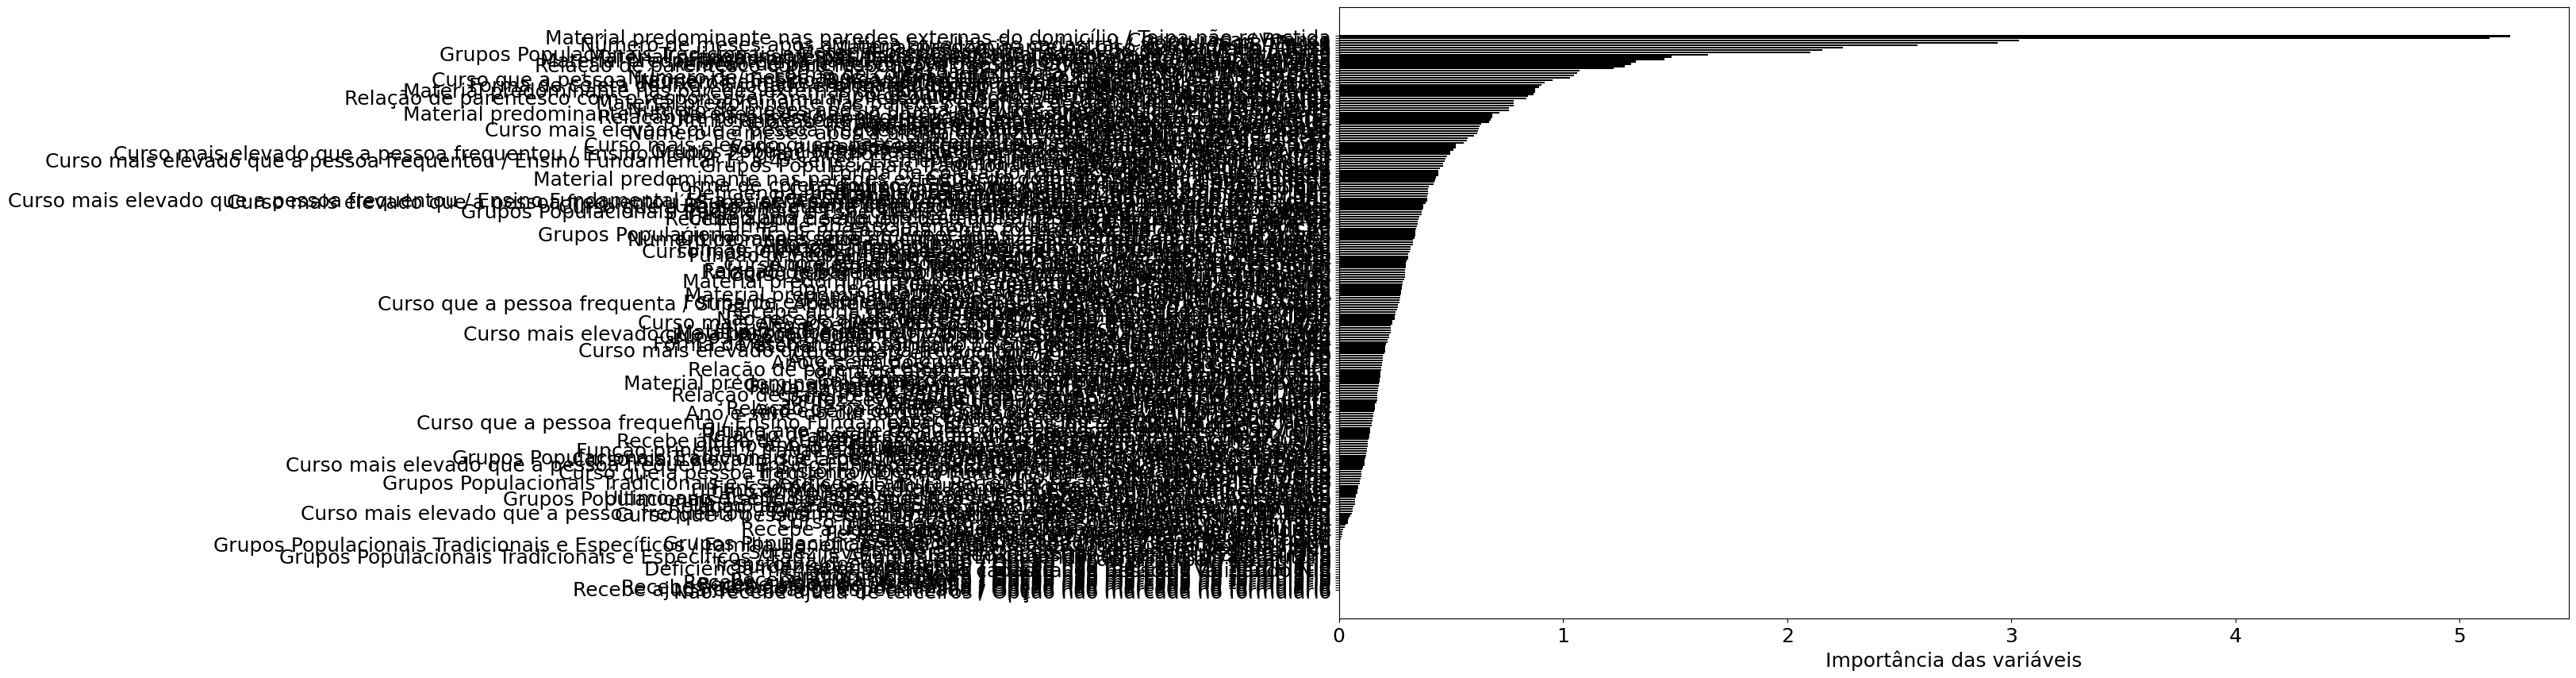

In [ ]:
plt.rcParams["figure.figsize"] = (20,10)
sorted_feature_importance = ctb.feature_importances_.argsort()
plt.barh(x_train.columns[sorted_feature_importance],
        ctb.feature_importances_[sorted_feature_importance],
        color='black')
plt.xlabel("Importância das variáveis", fontsize=18)
plt.tick_params(axis='both', which='major', labelsize=18)

In [ ]:
x_train.columns[sorted_feature_importance]

Index(['Não recebe ajuda de terceiros / Opção não marcada no formulário',
       'Recebe ajuda de cuidador especializado / Opção não marcada no formulário',
       'Recebe ajuda de alguém da família / Opção não marcada no formulário',
       'Recebe ajuda de instituição / Opção não marcada no formulário',
       'Recebe ajuda de outra forma / Opção não marcada no formulário',
       'Recebe ajuda de vizinho / Opção não marcada no formulário',
       'Cegueira / Opção não marcada no formulário',
       'Síndrome de Down / Opção não marcada no formulário',
       'Deficiência física / Opção não marcada no formulário',
       'Estado cadastral da pessoa / Validando NIS',
       ...
       'Função principal / Empregado com carteira de trabalho assinada',
       'Material predominante nas paredes externas do domicílio / Taipa revestida',
       'Grupos Populacionais Tradicionais e Específicos / Familia Catadores de Material Reciclavel',
       'Material predominante no piso do domicílio / C

In [ ]:
ctb.feature_importances_[sorted_feature_importance]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.07705430e-03,
       6.12743634e-03, 6.72992847e-03, 8.21462124e-03, 1.37800664e-02,
       1.51613446e-02, 1.58566803e-02, 1.97778156e-02, 2.68812925e-02,
       3.02117251e-02, 3.97522781e-02, 4.13971592e-02, 4.38473305e-02,
       5.13356594e-02, 5.72482263e-02, 6.03257108e-02, 6.08930312e-02,
       6.48605330e-02, 7.14007229e-02, 7.23236016e-02, 7.36594195e-02,
       7.62754349e-02, 7.69523831e-02, 8.10805073e-02, 8.41330814e-02,
       8.65652775e-02, 8.75378751e-02, 9.17020938e-02, 9.47952531e-02,
       9.78001532e-02, 9.97990990e-02, 1.00204592e-01, 1.01647694e-01,
       1.03772058e-01, 1.07235673e-01, 1.13331079e-01, 1.14662581e-01,
      